<a href="https://colab.research.google.com/github/Rktim/Fruit_Classifiaction/blob/main/CNN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


!unzip MY_data.zip


Archive:  MY_data.zip
   creating: MY_data/
   creating: MY_data/predict/
  inflating: MY_data/predict/0.jpeg  
  inflating: MY_data/predict/1.jpeg  
  inflating: MY_data/predict/2.jpeg  
  inflating: MY_data/predict/3.jpeg  
  inflating: MY_data/predict/4.jpeg  
  inflating: MY_data/predict/img_121.jpeg  
  inflating: MY_data/predict/img_141.jpeg  
  inflating: MY_data/predict/img_171.jpeg  
  inflating: MY_data/predict/img_191.jpeg  
  inflating: MY_data/predict/img_301.jpeg  
  inflating: MY_data/predict/img_341.jpeg  
  inflating: MY_data/predict/img_401.jpeg  
  inflating: MY_data/predict/img_411.jpeg  
  inflating: MY_data/predict/img_421.jpeg  
   creating: MY_data/test/
   creating: MY_data/test/apple/
  inflating: MY_data/test/apple/img_1001.jpeg  
  inflating: MY_data/test/apple/img_101.jpeg  
  inflating: MY_data/test/apple/img_1011.jpeg  
  inflating: MY_data/test/apple/img_1031.jpeg  
  inflating: MY_data/test/apple/img_1041.jpeg  
  inflating: MY_data/test/apple/img_1051.

In [ ]:
import torch
import torchvision
from torchvision import datasets ,transforms , models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import seaborn as sns



In [ ]:
trans=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

df_dir='/content/MY_data'

train_df=datasets.ImageFolder(root=f"{df_dir}/train",transform=trans)

test_df=datasets.ImageFolder(root=f"{df_dir}/test",transform=trans)

train_load=DataLoader(train_df,batch_size=32,shuffle=True)
test_load=DataLoader(test_df,batch_size=32,shuffle=False)

class_name=train_df.classes
num_classes=len(class_name)
print(f"Classes:{class_name}")

Classes:['Apple', 'Banana', 'mango']


In [ ]:
class Cnn(nn.Module):
    def __init__(self, num_classes):
        super(Cnn, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = Cnn(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def trainin(model,train_load,test_load, criterion,optimizer,n_e=20):
    dev=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model=model.to(dev)

    for epoch in range(n_e):
        print(f"\nEpoch {epoch+1}/{n_e} ----------------------")

        model.train()
        running_loss, correct_pred=0.0,0

        for inputs , labels in train_load:
            inputs,labels=inputs.to(dev),labels.to(dev)
            optimizer.zero_grad()

            output=model(inputs)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()

            running_loss+=loss.item()*inputs.size(0)
            _,preds=torch.max(output,1)

            correct_pred+=torch.sum(preds==labels.data)
        train_l=running_loss/len(train_load.dataset)
        train_acc=correct_pred.double()/len(train_load.dataset)
        print(f"Train loss:{train_l} , Train accuracy :{train_acc}")


In [ ]:
trainin(model, train_load, test_load, criterion, optimizer, n_e=20)
model.eval()
val_loss, val_correct_preds = 0.0, 0
dev=torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
        for inputs, labels in test_load:
                inputs, labels = inputs.to(dev), labels.to(dev)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct_preds += torch.sum(preds == labels.data)

val_loss = val_loss / len(test_load.dataset)
val_acc = val_correct_preds.double() / len(test_load.dataset)
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")



Epoch 1/20 ----------------------
Train loss:1.0290110901364715 , Train accuracy :0.5369030390738061

Epoch 2/20 ----------------------
Train loss:0.7644820514360143 , Train accuracy :0.6512301013024602

Epoch 3/20 ----------------------
Train loss:0.6341163794228378 , Train accuracy :0.7395079594790159

Epoch 4/20 ----------------------
Train loss:0.5478609934039468 , Train accuracy :0.7742402315484804

Epoch 5/20 ----------------------
Train loss:0.5867390895717913 , Train accuracy :0.7626628075253257

Epoch 6/20 ----------------------
Train loss:0.544505632130696 , Train accuracy :0.7727930535455861

Epoch 7/20 ----------------------
Train loss:0.5241980859322417 , Train accuracy :0.7655571635311144

Epoch 8/20 ----------------------
Train loss:0.49226540672106267 , Train accuracy :0.7800289435600579

Epoch 9/20 ----------------------
Train loss:0.47197816349490507 , Train accuracy :0.788712011577424

Epoch 10/20 ----------------------
Train loss:0.4492119489461399 , Train accuracy

Accuracy: 0.7367
Precision: 0.7480
Recall: 0.7367
F1-score: 0.7399


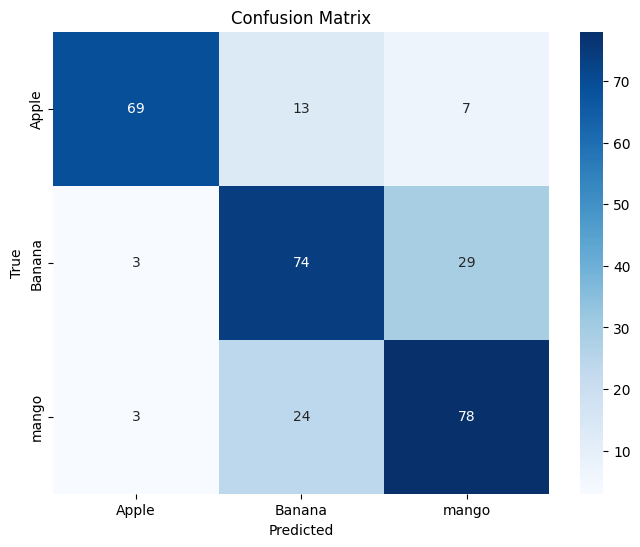

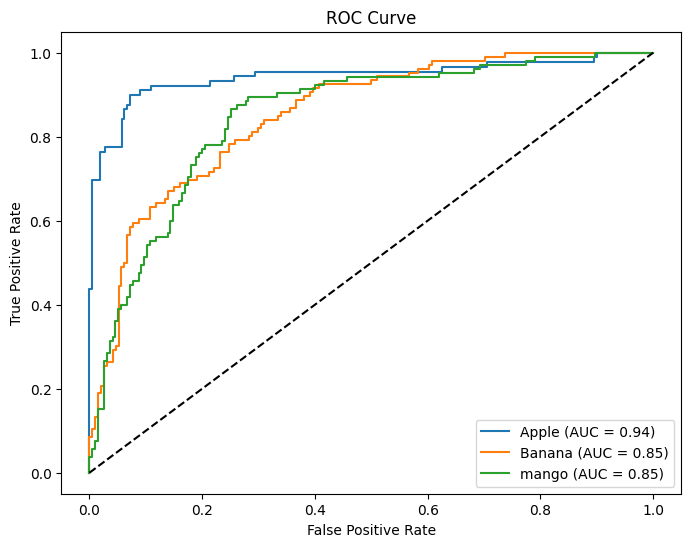

Micro-averaged AUC: 0.89


In [ ]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(dev), labels.to(dev)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs)

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')  # Use weighted average for multi-class
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve & AUC Score
    labels_bin = label_binarize(all_labels, classes=np.arange(len(class_names)))  # One-hot encoding
    fpr, tpr, roc_auc = {}, {}, {}

    plt.figure(figsize=(8, 6))

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    #  Micro-Averaged AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged AUC: {roc_auc['micro']:.2f}")
evaluate_model(model, test_load, class_name)


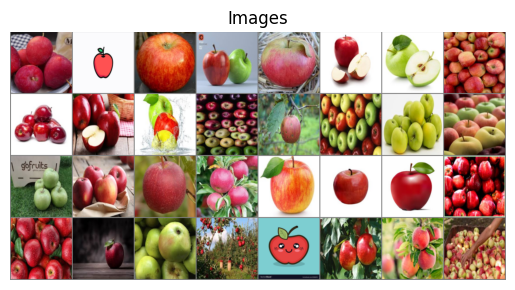


Structured Predictions Table:
 Image Index Actual Label Predicted Label
           0        Apple           Apple
           1        Apple           Apple
           2        Apple           Apple
           3        Apple           Apple
           4        Apple           Apple
           5        Apple           Apple
           6        Apple          Banana
           7        Apple           Apple
           8        Apple           Apple
           9        Apple           Apple
          10        Apple           Apple
          11        Apple           Apple
          12        Apple           Apple
          13        Apple           Apple
          14        Apple           mango
          15        Apple           Apple
          16        Apple          Banana
          17        Apple           Apple
          18        Apple           Apple
          19        Apple           Apple
          20        Apple           Apple
          21        Apple           Apple
   

In [ ]:
def imshow(img, title=None):
    """Displays an image grid with optional title."""
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title("Images")
    plt.axis("off")
    plt.show()

data_iter = iter(test_load)
images, labels = next(data_iter)
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels = images.to(dev), labels.to(dev)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

grid_img = torchvision.utils.make_grid(images.cpu())
imshow(grid_img, title="Sample Predictions")

df = pd.DataFrame({
    "Image Index": np.arange(len(labels.cpu())),
    "Actual Label": [class_name[l] for l in labels.cpu().numpy()],
    "Predicted Label": [class_name[p] for p in preds.cpu().numpy()],
})

print("\nStructured Predictions Table:")
print(df.to_string(index=False))